## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


## Exercicio com aproximação de primeiro ordem, progressivo no tempo e regressivo no espaço.
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

CFL:
$$
U*\frac{\Delta t}{\Delta x} < 1
$$

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def Conc(i, idx, nr, Co, dx):
    """
    Função de concentração com variação Gaussiana
    ---------------------------------------------
    i:      index
    idx:    central index
    nr:     número de pontos a partir do centro da gaussiana
    dx:     variação espacial em metros.
    Co:     Concentração do poluente, por exemplo ug/m3 em PM10
    """

    Conc = Co*np.exp(-(i*dx - idx*dx)**2/(nr*dx)**2)

    return Conc


def sol_num(idx, d_passos, aprox, cond_front, fun, hora, Co, dx, U_wind):
    """
    idx         : Ponto da grade.
    dpasos      : integer
    aprox       : Tipo de aproximação: "ordem1", "leapfrog", "ordem4", "Matsuno", "implicito", "RK4" (Runge Kutta 4).        
    cond_front  : Condição de fronteira: "fixa", "periódica" e "radicional".
    fun         : Função tipo "Gaussiana" e "Retângulo".
    hora        : Tempo em horas (int).
    Co          : Concentração do poluente, por exemplo ug/m3 em PM10.
    dx          : Resolução espacial em metros.
    """

    Nx     = 101                    # pontos totais da malha 1D
    Tempo  = hora*3600              # tempo total em segundos
    #dt     = dx/U_wind             # para ter CFL = 1
    dt     = 3*dx/1000              # passo de tempo , 6*dx/1000 baseado na recomendação WRF-Chem
    Nt     = int(Tempo/dt)          # número de passos de tempo
    U_wind                          # vento zonal m/s
    CFL = U_wind*dt/dx              # Courant number, ou CFL-number
    C = np.zeros((Nx + 1, Nt + 1))  # Matriz
    
    # Gaussiana
    # ---------
    if fun == "Gaussiana":
        fig, ax = plt.subplots(2, 1, figsize=[10, 8], sharex = True, gridspec_kw={'hspace': 0.1} )

        for j, nr in enumerate([10, 2]):

        # Condições iniciais
        # -------------------
            for i in range(Nx + 1):
                C[i,0] = Conc(i, idx, nr, Co, dx)

            ax[j].plot(C[:,0], color = 'b', lw=3, label="Condição inicial")

            for n in range(1, Nt+1):
   
                if n % d_passos == 0:
                    ax[j].plot(C[:,n], color='m', linestyle='dashed', label=f"PT {n}")

                for i in range(1,Nx+1):

                    # Aproximação numérica:
                    # ---------------------
                    if aprox == "ordem1":
                        C[i,n] = C[i, n-1] - U_wind*dt/dx*(C[i, n-1]- C[i-1, n-1])
                
                    elif aprox == "leapfrog":
                        C[i,n+1] = C[i, n-1] - U_wind*dt/dx*(C[i+1, n]- C[i-1, n])

                    elif aprox == "ordem4":
                        C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso
                
                    elif aprox == "Matsuno":
                        C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso
                
                    elif aprox == "implicito":
                        C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso

                    elif aprox == "RK4":
                        C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso

                    # Condição de fronteira
                    # ---------------------
                    if cond_front == 'fixa':
                        C[[0,-1], n] = [0,0]

                    elif cond_front == 'periódica':
                        C[[0, 1], n] = C[[-1,-2],n-1]
                
                    elif cond_front == 'radiacional':
                        C[-1, n] = C[-1, n]
            
            ax[j].plot(C[:,-1], color='g', lw=3, label = f"Final {Tempo/3600} horas ")
            ax[j].set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
            ax[j].set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos, $\Delta$x = {dx} metros e nr = {nr}.",loc='left')
            ax[0].legend(fontsize=8, ncol=2)
            ax[1].set_xlabel("Pontos da grade")
            ax[1].text(2,3, r"$\vec U$ = "+ f"{U_wind} m/s.", fontsize=12)
            ax[1].text(2,4, f"CFL = {CFL}", fontsize=12)
            fig.suptitle(f"Solução numérica com função {fun} \n e condição de fronteira de tipo {cond_front}", fontweight='bold' )
            fig.savefig("fig/" + aprox + "_" + fun[:3] + "_" + cond_front[:3] +"_" + str(hora) +"h.png", dpi = 300, bbox_inches='tight', facecolor='w')

    # Retangulo
    # ---------
    if fun == "Retângulo":
        fig, ax = plt.subplots(1, figsize=[8, 5])

        # Condições iniciais
        # -------------------
        for i in range(Nx + 1):
            C[[int(idx - 2/2), idx, int(idx + 2/2)], 0] = 1/2*Co

        ax.plot(C[:,0], color = 'b', lw=3, label="Condição inicial")

        for n in range(1, Nt+1):
   
            if n % d_passos == 0:
                ax.plot(C[:,n], color='m', linestyle='dashed', label=f"PT {n}")

            for i in range(1,Nx+1):

                # Aproximação numérica:
                # ---------------------
                if aprox == "ordem1":
                    C[i,n] = C[i, n-1] - U_wind*dt/dx*(C[i, n-1]- C[i-1, n-1])
                
                elif aprox == "leapfrog":
                    C[i, n+1] = C[i, n-1] - U_wind*dt/dx*(C[i+1, n]- C[i-1, n])

                elif aprox == "ordem4":
                    C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso
                
                elif aprox == "Matsuno":
                    C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso
                
                elif aprox == "implicito":
                    C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso

                elif aprox == "RK4":
                    C[i,n+1] = C[i, n] - U_wind*dt/dx*(C[i, n]- C[i-1, n])  # mudar isso

                # Condição de fronteira
                # ---------------------
                if cond_front == 'fixa':
                    C[[0,-1], n] = [0,0]

                elif cond_front == 'periódica':
                    C[[0, 1], n] = C[[-1,-2],n-1]
                
                elif cond_front == 'radiacional':
                    C[-1, n] = C[-1, n]
            
        ax.plot(C[:,-1], color='g', lw=3, label = f"Final {Tempo/3600} horas ")
        ax.set_ylabel("PM$_{10}$ ($\mu$g.m$^{-3}$)")
        ax.set_title("Variação da concentração"+f" para $\Delta$t = {dt} segundos, $\Delta$x = {dx} metros.", loc='left', fontsize=8)
        ax.legend(fontsize=8, ncol=2)
        ax.set_xlabel("Pontos da grade")
        ax.text(2,3, r"$\vec U$ = "+ f"{U_wind} m/s.", fontsize=12)
        ax.text(2,4, f"CFL = {CFL}", fontsize=12)
        fig.suptitle(f"Solução numérica com função {fun} \n e condição de fronteira de tipo {cond_front}", fontweight='bold', y = 0.99)
        fig.savefig("fig/" + aprox + "_" + fun[:3] + "_" + cond_front[:3] +"_" + str(hora) +"h.png", dpi = 300, bbox_inches='tight', facecolor='w')

    return C



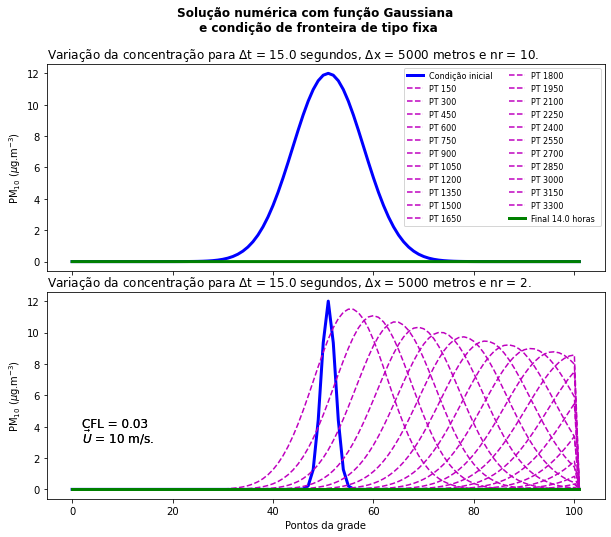

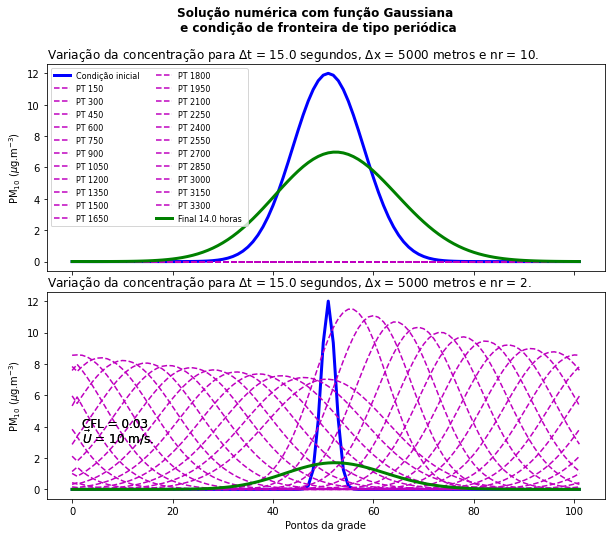

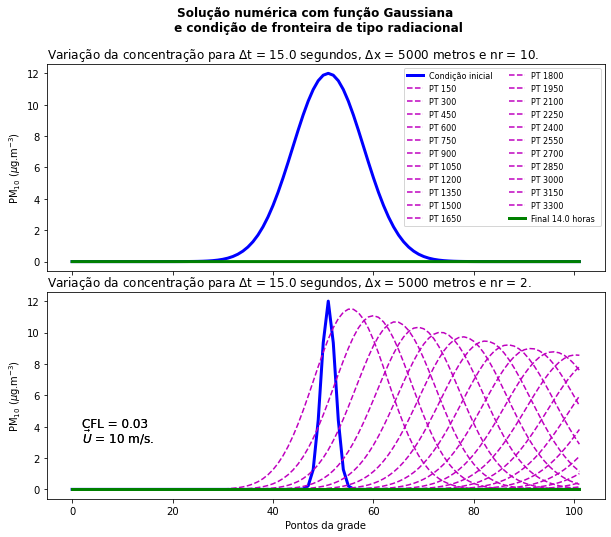

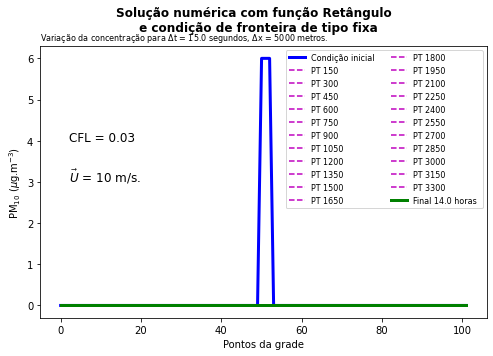

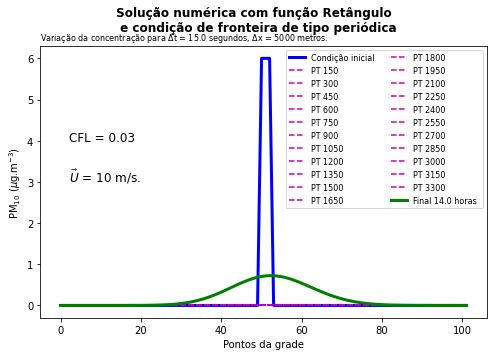

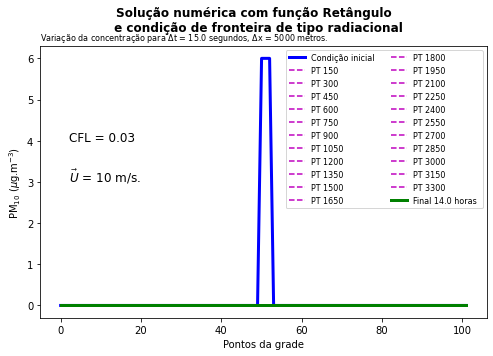

In [56]:
for f in ['Gaussiana', 'Retângulo']:
    
    for tipo in ['fixa', 'periódica', 'radiacional']:
        
        sol_num(idx = 51,
                d_passos = 150,
                cond_front = tipo,
                aprox = "ordem1",
                fun = f, 
                hora = 14, 
                Co = 12, 
                dx = 5000, 
                U_wind = +10)